In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import hog
from tqdm import tqdm


In [7]:
df["label"] = df.iloc[:, 1:].idxmax(axis=1)

# Map string labels to integers
label_map = {label: idx for idx, label in enumerate(df["label"].unique())}
df["label_idx"] = df["label"].map(label_map)

print("✅ Label Map:", label_map)
df[["image_id", "label", "label_idx"]].head()

✅ Label Map: {'scab': 0, 'multiple_diseases': 1, 'healthy': 2, 'rust': 3}


,image_id,label,label_idx
0,Train_0,scab,0
1,Train_1,multiple_diseases,1
2,Train_2,healthy,2
3,Train_3,rust,3
4,Train_4,healthy,2


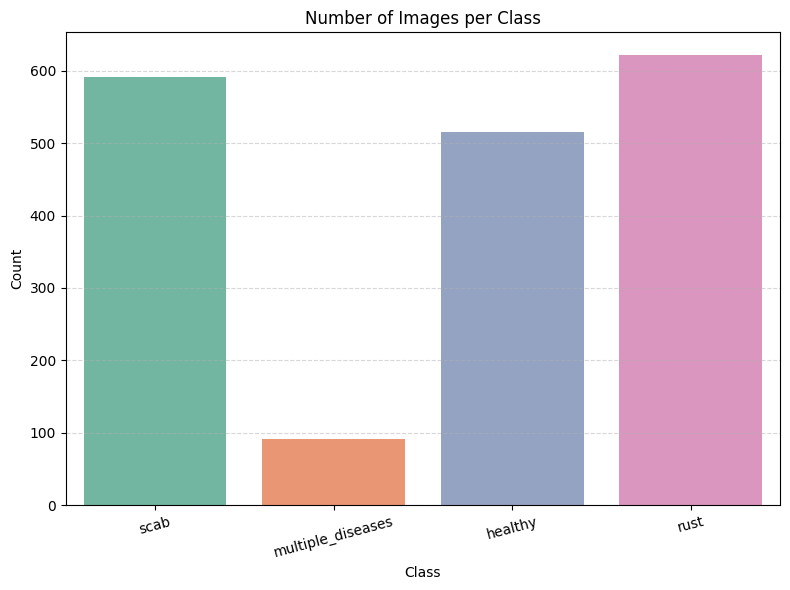

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")

# Convert one-hot labels to a single class label
df["label"] = df.iloc[:, 1:].idxmax(axis=1)

# Count plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="Set2")

plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# using HOG as Feature Extractor

In [8]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # HOG features
    hog_features = hog(gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), feature_vector=True)
    
    # Color histogram (RGB)
    hist_r = cv2.calcHist([image], [0], None, [32], [0, 256]).flatten()
    hist_g = cv2.calcHist([image], [1], None, [32], [0, 256]).flatten()
    hist_b = cv2.calcHist([image], [2], None, [32], [0, 256]).flatten()
    
    features = np.concatenate([hog_features, hist_r, hist_g, hist_b])
    return features


In [9]:
features = []
labels = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(DATA_DIR, "images", row["image_id"] + ".jpg")
    feat = extract_features(img_path)
    features.append(feat)
    labels.append(row["label_idx"])

X = np.array(features)
y = np.array(labels)

print("Feature shape:", X.shape)


100%|██████████| 1821/1821 [01:10<00:00, 25.90it/s]


Feature shape: (1821, 8196)


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)



✅ SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.65      0.59       127
           1       0.29      0.11      0.16        18
           2       0.53      0.47      0.50       100
           3       0.48      0.46      0.47       120

    accuracy                           0.51       365
   macro avg       0.46      0.42      0.43       365
weighted avg       0.50      0.51      0.50       365



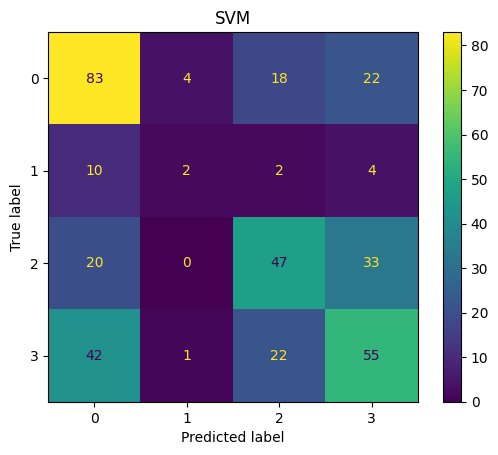


✅ RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       127
           1       0.00      0.00      0.00        18
           2       0.51      0.40      0.45       100
           3       0.41      0.46      0.43       120

    accuracy                           0.45       365
   macro avg       0.35      0.35      0.35       365
weighted avg       0.44      0.45      0.44       365



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


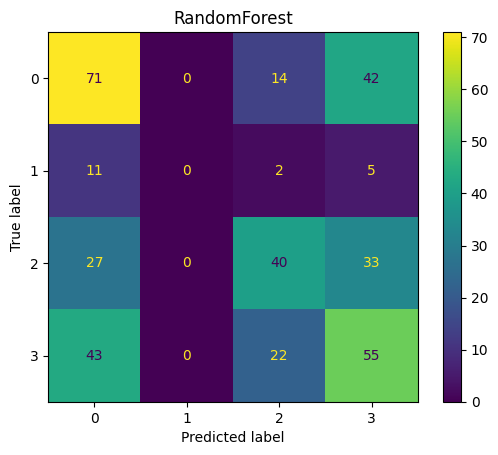


✅ GradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.53      0.49       127
           1       0.00      0.00      0.00        18
           2       0.48      0.46      0.47       100
           3       0.39      0.40      0.40       120

    accuracy                           0.44       365
   macro avg       0.33      0.35      0.34       365
weighted avg       0.42      0.44      0.43       365



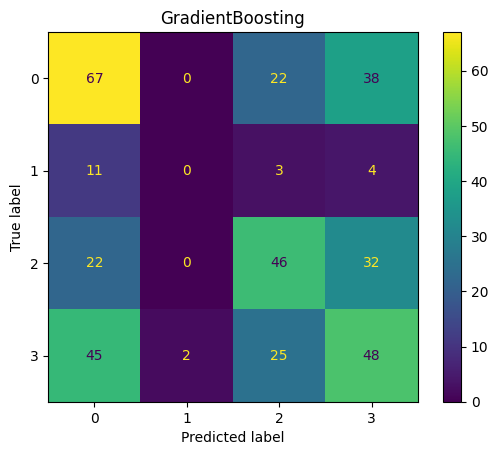

In [15]:
models = {
    "SVM": SVC(kernel="rbf", C=10, gamma="scale"),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n✅ {name} Classification Report:")
    print(classification_report(y_test, preds))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(name)
    plt.show()


In [12]:
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")
sample_sub = pd.read_csv(f"{DATA_DIR}/sample_submission.csv")

# Extract features for test images
test_features = []
for img_id in tqdm(test_df["image_id"]):
    path = os.path.join(DATA_DIR, "images", img_id + ".jpg")
    feat = extract_features(path)
    test_features.append(feat)

X_test_final = pca.transform(scaler.transform(test_features))
final_preds = models["RandomForest"].predict(X_test_final)

# Reverse label map
rev_label_map = {v: k for k, v in label_map.items()}
final_labels = [rev_label_map[p] for p in final_preds]

# Create submission
sample_sub["label"] = final_labels
sample_sub.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")


100%|██████████| 1821/1821 [00:59<00:00, 30.48it/s]


✅ submission.csv saved!


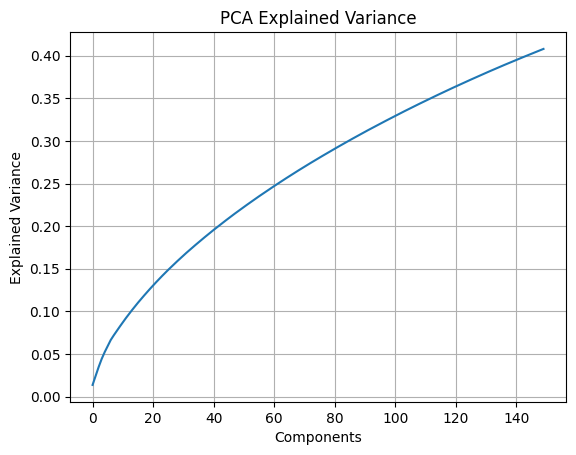

In [13]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()


## Visualization

In [16]:
from skimage.feature import local_binary_pattern, hog
from skimage import exposure
import cv2
import matplotlib.pyplot as plt
import os


In [30]:
def plot_lbp_hog_comparison(image_ids, n_images=3):
    plt.figure(figsize=(12, 6 * n_images))

    for i, img_id in enumerate(image_ids[:n_images]):
        path = os.path.join(DATA_DIR, "images", img_id + ".jpg")
        image = cv2.imread(path)
        image = cv2.resize(image, (128, 128))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # -- LBP
        lbp = local_binary_pattern(gray, P=8, R=24, method='uniform')

        # -- HOG
        hog_features, hog_image = hog(gray,
                                      pixels_per_cell=(8, 8),
                                      cells_per_block=(4, 4),
                                      visualize=True,
                                      feature_vector=True)
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        # Plot Original + LBP + HOG
        plt.subplot(n_images, 3, i * 3 + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {img_id}")
        plt.axis("off")

        plt.subplot(n_images, 3, i * 3 + 2)
        plt.imshow(lbp, cmap="gray")
        plt.title("LBP Texture")
        plt.axis("off")

        plt.subplot(n_images, 3, i * 3 + 3)
        plt.imshow(hog_image_rescaled, cmap="gray")
        plt.title("HOG Gradient")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


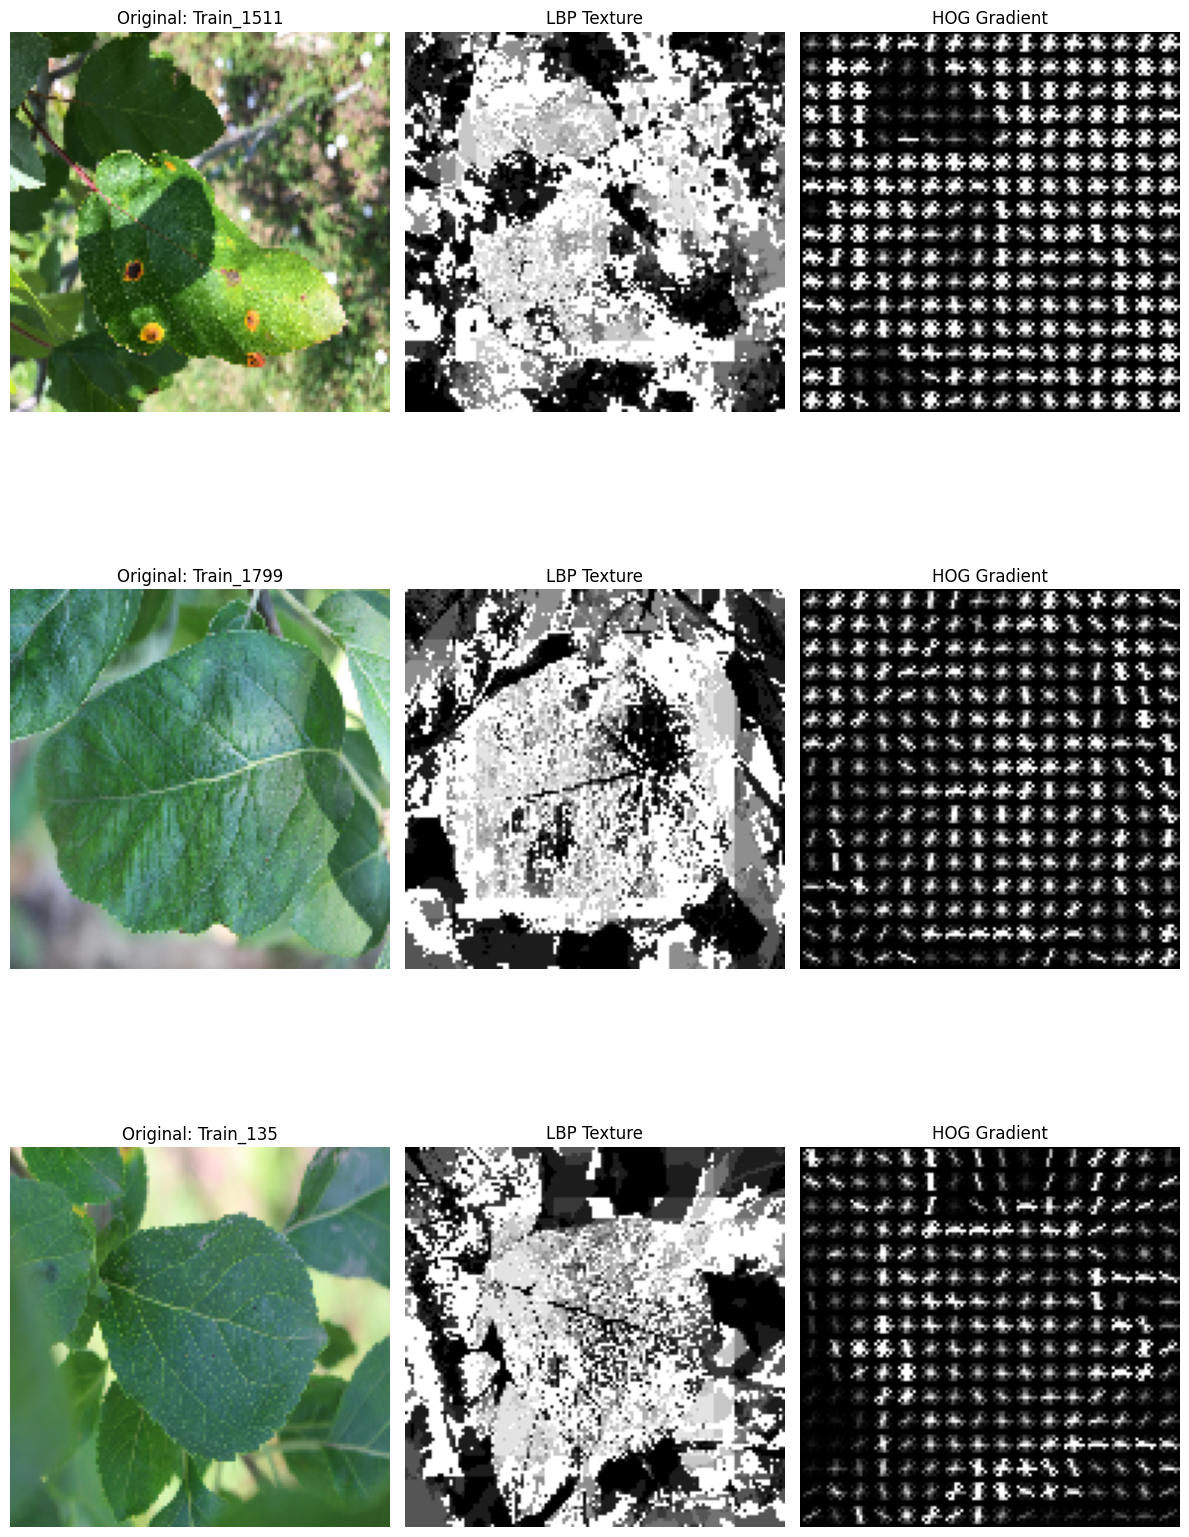

In [31]:
sample_ids = df["image_id"].sample(3, random_state=42).tolist()
plot_lbp_hog_comparison(sample_ids)


# Using LBP as feature Extractor

In [32]:
def extract_lbp_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 10),  # 0 to 9 uniform patterns
                             range=(0, 9))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalize
    return hist


In [33]:
features = []
labels = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(DATA_DIR, "images", row["image_id"] + ".jpg")
    feat = extract_lbp_features(img_path)
    features.append(feat)
    labels.append(row["label_idx"])

X = np.array(features)
y = np.array(labels)
print("LBP Feature Shape:", X.shape)


100%|██████████| 1821/1821 [00:34<00:00, 53.51it/s]

LBP Feature Shape: (1821, 9)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)


In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

grid_svm = GridSearchCV(SVC(), param_grid=param_svm, cv=3, scoring='f1_weighted', verbose=1)
grid_svm.fit(X_train, y_train)

print("✅ Best SVM Params:", grid_svm.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Best SVM Params: {'C': 1, 'class_weight': 'balanced', 'kernel': 'rbf'}


In [36]:
from sklearn.ensemble import RandomForestClassifier

param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced']
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_rf, cv=3, scoring='f1_weighted', verbose=1)
grid_rf.fit(X_train, y_train)

print("✅ Best RF Params:", grid_rf.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
✅ Best RF Params: {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 200}


In [37]:
from sklearn.ensemble import GradientBoostingClassifier

param_gbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

grid_gbm = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=param_gbm, cv=3, scoring='f1_weighted', verbose=1)
grid_gbm.fit(X_train, y_train)

print("✅ Best GBM Params:", grid_gbm.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
✅ Best GBM Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}



🎯 SVM (Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.58      0.38      0.46       119
           1       0.08      0.39      0.13        18
           2       0.49      0.48      0.49       103
           3       0.43      0.35      0.39       125

    accuracy                           0.40       365
   macro avg       0.40      0.40      0.37       365
weighted avg       0.48      0.40      0.43       365



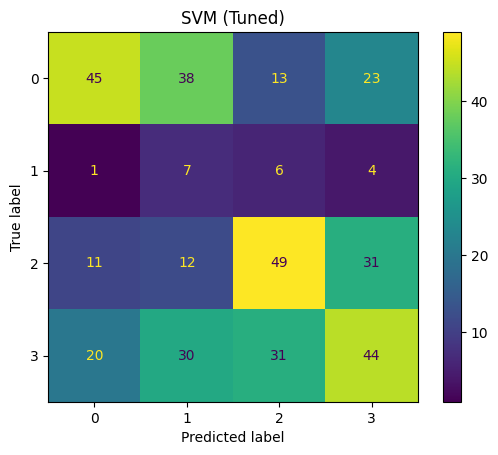


🎯 RandomForest (Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       119
           1       0.00      0.00      0.00        18
           2       0.46      0.46      0.46       103
           3       0.43      0.50      0.46       125

    accuracy                           0.48       365
   macro avg       0.36      0.37      0.37       365
weighted avg       0.46      0.48      0.47       365



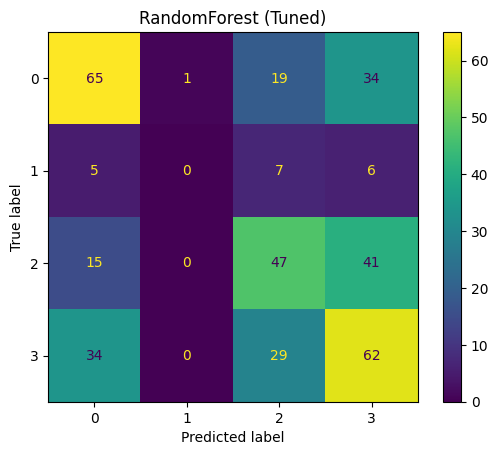


🎯 GradientBoosting (Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.57      0.53      0.55       119
           1       0.00      0.00      0.00        18
           2       0.49      0.39      0.43       103
           3       0.42      0.58      0.49       125

    accuracy                           0.48       365
   macro avg       0.37      0.37      0.37       365
weighted avg       0.47      0.48      0.47       365



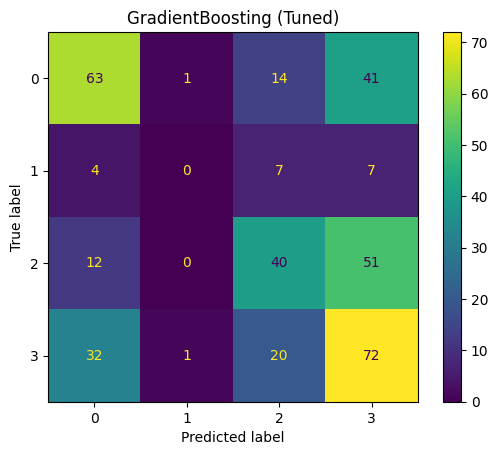

In [38]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

models = {
    "SVM (Tuned)": grid_svm.best_estimator_,
    "RandomForest (Tuned)": grid_rf.best_estimator_,
    "GradientBoosting (Tuned)": grid_gbm.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n🎯 {name} Evaluation:")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(name)
    plt.show()


## LBP + KNN

In [40]:
# Step 1: Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# Constants for LBP
METHOD = 'uniform'
lbp_params_grid = [(8,1), (16,2), (24,3)]  # (P, R) combinations

# Step 2: Load Data
df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')

# Convert one-hot labels to class label
df['label'] = df.iloc[:, 1:].idxmax(axis=1)
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(label_map)
print("✅ Label mapping:", label_map)

# Step 3: Extract LBP Features Function
def extract_lbp_features(image, P, R):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, METHOD)
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, P + 3),
                             range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Step 4: Feature Extraction for All Images with All P, R Combinations
image_dir = "/kaggle/input/plant-pathology-2020-fgvc7/images"
features_dict = {}
labels = []

for (P, R) in lbp_params_grid:
    feature_list = []
    for img_id in tqdm(df["image_id"], desc=f"LBP(P={P}, R={R})"):
        img_path = os.path.join(image_dir, img_id + ".jpg")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        features = extract_lbp_features(img, P, R)
        feature_list.append(features)
    features_dict[(P, R)] = np.array(feature_list)

labels = df["label_idx"].values

# Step 5: Train Models for Each (P, R) and Compare
results = []

for (P, R), X in features_dict.items():
    print(f"\n🔍 Training for LBP(P={P}, R={R})")

    # Split and Scale
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- KNN ---
    print("📌 KNN:")
    best_knn_score = 0
    best_k = None
    for k in [3, 5, 7]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"K={k}, Accuracy={acc:.4f}")
        if acc > best_knn_score:
            best_knn_score = acc
            best_k = k
            best_knn_model = knn
            best_knn_preds = y_pred

    # --- SVM ---
    print("📌 SVM:")
    best_svm_score = 0
    for c in [0.1, 1, 10]:
        svm = SVC(C=c, kernel='rbf')
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"C={c}, Accuracy={acc:.4f}")
        if acc > best_svm_score:
            best_svm_score = acc
            best_svm_model = svm
            best_svm_preds = y_pred

    results.append({
        "LBP_P": P,
        "LBP_R": R,
        "Best_KNN_Acc": best_knn_score,
        "Best_K": best_k,
        "Best_SVM_Acc": best_svm_score
    })

    print("✅ Best KNN Classification Report:\n", classification_report(y_test, best_knn_preds, target_names=label_map.keys()))
    print("✅ Best SVM Classification Report:\n", classification_report(y_test, best_svm_preds, target_names=label_map.keys()))

# Step 6: Summary Table
summary_df = pd.DataFrame(results)
print("\n📊 LBP + Model Accuracy Summary")
display(summary_df)


✅ Label mapping: {'scab': 0, 'multiple_diseases': 1, 'healthy': 2, 'rust': 3}


LBP(P=24, R=3): 100%|██████████| 1821/1821 [00:42<00:00, 43.13it/s]



🔍 Training for LBP(P=8, R=1)
📌 KNN:
K=3, Accuracy=0.4575
K=5, Accuracy=0.4548
K=7, Accuracy=0.4685
📌 SVM:
C=0.1, Accuracy=0.5068
C=1, Accuracy=0.4932
C=10, Accuracy=0.4904
✅ Best KNN Classification Report:
                    precision    recall  f1-score   support

             scab       0.52      0.55      0.53       119
multiple_diseases       0.00      0.00      0.00        18
          healthy       0.49      0.48      0.49       103
             rust       0.41      0.46      0.43       125

         accuracy                           0.47       365
        macro avg       0.36      0.37      0.36       365
     weighted avg       0.45      0.47      0.46       365

✅ Best SVM Classification Report:
                    precision    recall  f1-score   support

             scab       0.58      0.60      0.59       119
multiple_diseases       0.00      0.00      0.00        18
          healthy       0.55      0.33      0.41       103
             rust       0.44      0.64      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C=0.1, Accuracy=0.4904
C=1, Accuracy=0.5041
C=10, Accuracy=0.5315
✅ Best KNN Classification Report:
                    precision    recall  f1-score   support

             scab       0.52      0.61      0.56       119
multiple_diseases       0.14      0.06      0.08        18
          healthy       0.49      0.51      0.50       103
             rust       0.47      0.41      0.44       125

         accuracy                           0.49       365
        macro avg       0.40      0.40      0.39       365
     weighted avg       0.47      0.49      0.48       365

✅ Best SVM Classification Report:
                    precision    recall  f1-score   support

             scab       0.59      0.61      0.60       119
multiple_diseases       0.00      0.00      0.00        18
          healthy       0.48      0.44      0.46       103
             rust       0.52      0.62      0.56       125

         accuracy                           0.53       365
        macro avg       0.40     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C=0.1, Accuracy=0.4740
C=1, Accuracy=0.5014
C=10, Accuracy=0.5260
✅ Best KNN Classification Report:
                    precision    recall  f1-score   support

             scab       0.40      0.56      0.47       119
multiple_diseases       0.08      0.06      0.06        18
          healthy       0.54      0.38      0.45       103
             rust       0.45      0.40      0.42       125

         accuracy                           0.43       365
        macro avg       0.37      0.35      0.35       365
     weighted avg       0.44      0.43      0.43       365

✅ Best SVM Classification Report:
                    precision    recall  f1-score   support

             scab       0.56      0.60      0.58       119
multiple_diseases       0.00      0.00      0.00        18
          healthy       0.56      0.50      0.53       103
             rust       0.48      0.55      0.51       125

         accuracy                           0.53       365
        macro avg       0.40     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,LBP_P,LBP_R,Best_KNN_Acc,Best_K,Best_SVM_Acc
0,8,1,0.468493,7,0.506849
1,16,2,0.487671,5,0.531507
2,24,3,0.430137,3,0.526027
